In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix, roc_auc_score,
                             plot_roc_curve)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 9 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 16.9 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 666 µs


### Database ERD

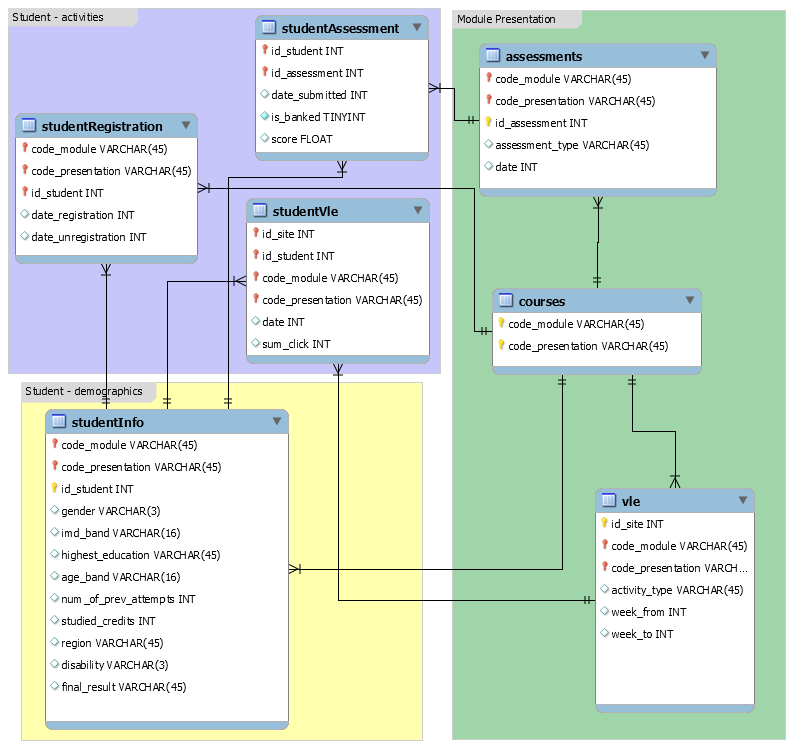

time: 3.76 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.67 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.34 ms


## Half Term Data

In [8]:
# database_name = 'outcomes.db'
# db_new = db.Database(database_name)

time: 650 µs


In [9]:
df = db.data_prep(120)

time: 12.9 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23261 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 23237 non-null  object 
 3   gender                23261 non-null  object 
 4   region                23261 non-null  object 
 5   highest_education     23261 non-null  object 
 6   imd_band              22335 non-null  object 
 7   age_band              23261 non-null  object 
 8   num_of_prev_attempts  23261 non-null  float64
 9   studied_credits       23261 non-null  float64
 10  disability            23261 non-null  object 
 11  final_result          23261 non-null  object 
 12  date_sub              23261 non-null  float64
 13  course_length         23261 non-null  float64
 14  weighted_ave          23255 non-null  float64
 15  mean_score         

In [11]:
df.describe()

,target,num_of_prev_attempts,studied_credits,date_sub,course_length,weighted_ave,mean_score,median_score,sum_activity,max_date,date_registration,date_unregistration
count,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23255.000000,23255.000000,23255.000000,23261.000000,23261.000000,24770.000000,2255.000000
mean,0.340398,0.152702,75.350802,25.388074,239.679249,115.535241,75.167841,75.520490,1184.305791,-8.732514,-65.488736,170.795565
std,0.473853,0.462228,37.119805,14.408581,5.617692,72.955003,15.072363,15.022744,1259.735843,11.380161,47.117116,33.475645
min,0.000000,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,2.000000,-25.000000,-311.000000,121.000000
25%,0.000000,0.000000,60.000000,18.000000,240.000000,67.200000,67.428571,67.500000,378.000000,-17.000000,-94.000000,144.000000
50%,0.000000,0.000000,60.000000,21.000000,240.000000,120.240000,78.285714,78.000000,786.000000,-10.000000,-52.000000,165.000000
75%,1.000000,0.000000,90.000000,31.000000,241.000000,160.000000,86.000000,86.000000,1518.000000,-4.000000,-29.000000,198.000000
max,1.000000,6.000000,630.000000,119.000000,268.000000,663.660000,100.000000,100.000000,15828.000000,117.000000,167.000000,444.000000


time: 69.2 ms


In [12]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

time: 897 µs


In [13]:
df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 67.4 ms


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20856 entries, 0 to 20855
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20856 non-null  float64 
 1   gender                20856 non-null  object  
 2   region                20856 non-null  object  
 3   highest_education     20856 non-null  object  
 4   imd_band              20856 non-null  object  
 5   age_band              20856 non-null  object  
 6   num_of_prev_attempts  20856 non-null  float64 
 7   disability            20856 non-null  object  
 8   weighted_ave          20856 non-null  float64 
 9   mean_score            20856 non-null  float64 
 10  median_score          20856 non-null  float64 
 11  sum_activity          20856 non-null  float64 
 12  course_load           20856 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 1.9+ MB
time: 17.9 ms


In [15]:
df.target.value_counts(normalize=True)

0.0    0.657796
1.0    0.342204
Name: target, dtype: float64

time: 4.07 ms


In [129]:
df.describe()

,target,num_of_prev_attempts,weighted_ave,mean_score,median_score,sum_activity
count,20856.000000,20856.000000,20856.000000,20856.000000,20856.000000,20856.000000
mean,0.342204,0.137514,109.848172,74.930683,75.248298,1151.691072
std,0.474459,0.444558,65.777948,15.107284,15.008696,1238.394293
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,64.700000,67.250000,67.000000,366.000000
50%,0.000000,0.000000,117.720000,78.000000,78.000000,758.000000
75%,1.000000,0.000000,156.660000,85.666667,86.000000,1466.250000
max,1.000000,6.000000,299.920000,100.000000,100.000000,15828.000000


time: 54.8 ms


## Creating Holdout Data

In [16]:
# splitting data & target
X, y = f.X_y(df)

time: 2.98 ms


In [17]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 12.7 ms


## Creating Training Data

In [18]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.57 ms


## Baseline Model: Dummy Classifier

In [19]:
dummy = DummyClassifier(strategy='most_frequent')

time: 886 µs


In [20]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 1.45 ms


### Fitting Model

In [21]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 66.7 ms


### Saving Model

In [22]:
# f.pickle_model(baseline, 'baseline')

time: 701 µs


### Cross Val Scores

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6577444278687744
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 270 ms


### Test Data Confusion Matrix

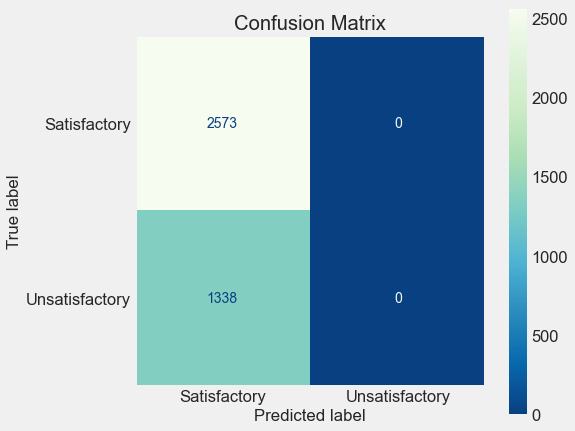

,Accuracy,F1,Recall,Precision
0,0.657888,0.0,0.0,0.0


time: 416 ms


In [24]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [25]:
mnb = MultinomialNB()

time: 859 µs


In [26]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 957 µs


### Fitting Model

In [27]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>)])),
                ('multinomialnb', MultinomialNB())])

time: 44.1 ms


### Saving Model

In [28]:
# f.pickle_model(fsm, 'fsm')

time: 765 µs


### Cross Val Scores

In [29]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6621771058880194
 fsm has an average F1 of 0.2394766768920708
 fsm has an average Recall of 0.15541718555417186
 fsm has an average Precision of 0.5230166648140284


[0.6621771058880194,
 0.2394766768920708,
 0.15541718555417186,
 0.5230166648140284]

time: 242 ms


### Test Data Confusion Matrix

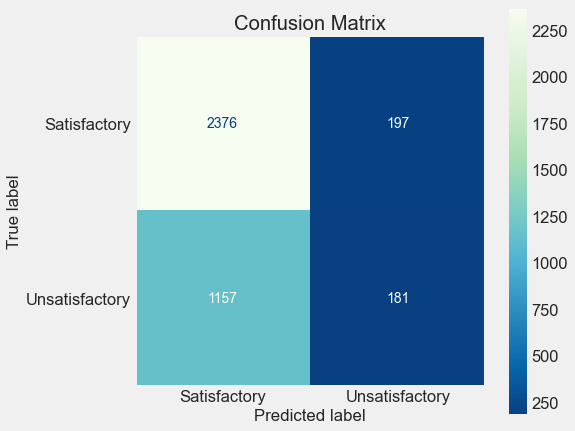

,Accuracy,F1,Recall,Precision
0,0.653797,0.210956,0.135277,0.478836


time: 378 ms


In [30]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [31]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 885 µs


In [32]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.06 ms


### Fitting Model

In [33]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 55.2 ms


In [34]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 715 µs


### Cross Val Scores

In [35]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7202287224517269
knn_ss has an average F1 of 0.5547792077480163
knn_ss has an average Recall of 0.5093399750933998
knn_ss has an average Precision of 0.6092796506039889


[0.7202287224517269,
 0.5547792077480163,
 0.5093399750933998,
 0.6092796506039889]

time: 5.3 s


### Test Data Confusion Matrix

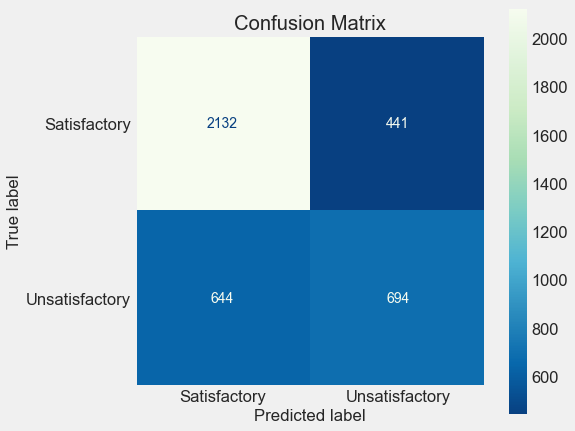

,Accuracy,F1,Recall,Precision
0,0.722577,0.561262,0.518685,0.611454


time: 11.4 s


In [36]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [37]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 1.23 ms


In [38]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.2 ms


### Fitting Model

In [39]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.12 s


In [40]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 912 µs


### Cross Val Scores

In [41]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7460574181692833
logreg_ss has an average F1 of 0.5685533985697682
logreg_ss has an average Recall of 0.48891656288916563
logreg_ss has an average Precision of 0.6795598564315523


[0.7460574181692833,
 0.5685533985697682,
 0.48891656288916563,
 0.6795598564315523]

time: 2.2 s


### Test Data Confusion Matrix

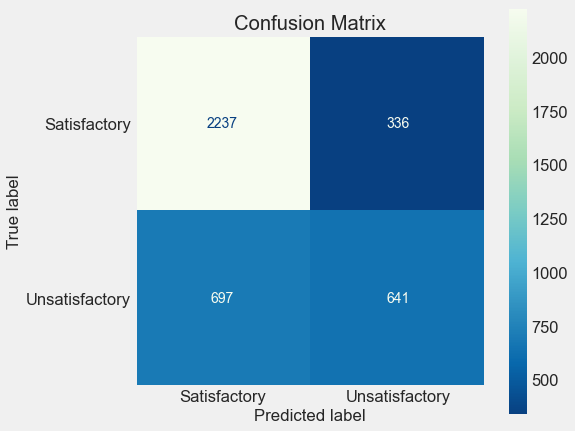

,Accuracy,F1,Recall,Precision
0,0.735873,0.55378,0.479073,0.65609


time: 282 ms


In [42]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [43]:
SVC = SVC()

time: 1.05 ms


In [44]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.2 ms


### Fitting Model

In [45]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('svc', SVC())])

time: 7.03 s


In [46]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 670 µs


### Cross Val Scores

In [47]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7572242012530916
svc_ss has an average F1 of 0.5844504759440243
svc_ss has an average Recall of 0.49887920298879196
svc_ss has an average Precision of 0.705680099995632


[0.7572242012530916,
 0.5844504759440243,
 0.49887920298879196,
 0.705680099995632]

time: 25.8 s


### Test Data Confusion Matrix

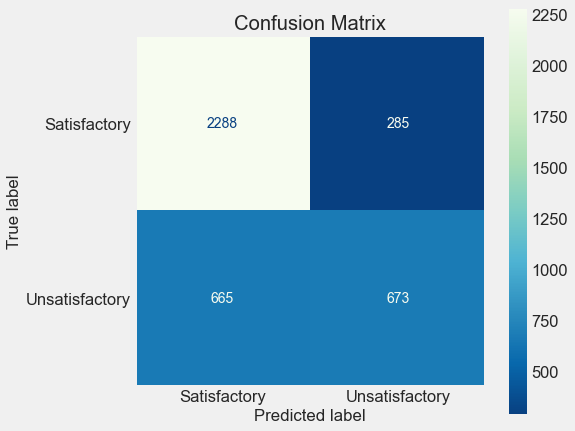

,Accuracy,F1,Recall,Precision
0,0.757095,0.586237,0.50299,0.702505


time: 7.23 s


In [48]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [49]:
LSVC = LinearSVC(random_state=2021)

time: 1.51 ms


In [50]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 994 µs


### Fitting Model

In [51]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 775 ms


In [52]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 737 µs


### Cross Val Scores

In [53]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.745886915185481
lsvc_ss has an average F1 of 0.5610543100296257
lsvc_ss has an average Recall of 0.47447073474470736
lsvc_ss has an average Precision of 0.6867402165830143


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.745886915185481,
 0.5610543100296257,
 0.47447073474470736,
 0.6867402165830143]

time: 3.18 s


### Test Data Confusion Matrix

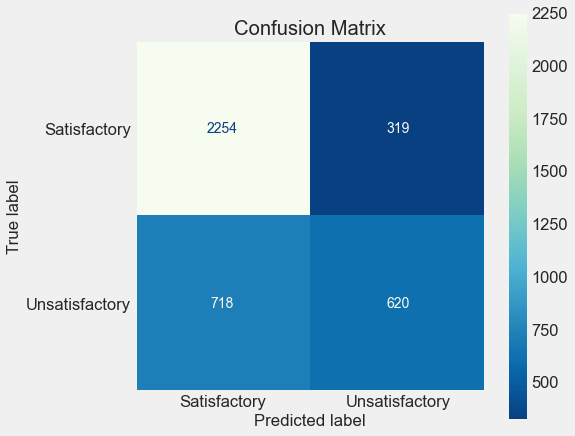

,Accuracy,F1,Recall,Precision
0,0.73485,0.544576,0.463378,0.660277


time: 268 ms


In [54]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [55]:
DT = DecisionTreeClassifier(random_state=2021)

time: 1.04 ms


In [56]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 986 µs


### Fitting Model

In [57]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 543 ms


In [58]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 767 µs


### Cross Val Scores

In [59]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.690818265395486
dt_ss has an average F1 of 0.5526333896745442
dt_ss has an average Recall of 0.5581569115815691
dt_ss has an average Precision of 0.5474929504232426


[0.690818265395486, 0.5526333896745442, 0.5581569115815691, 0.5474929504232426]

time: 2.37 s


### Test Data Confusion Matrix

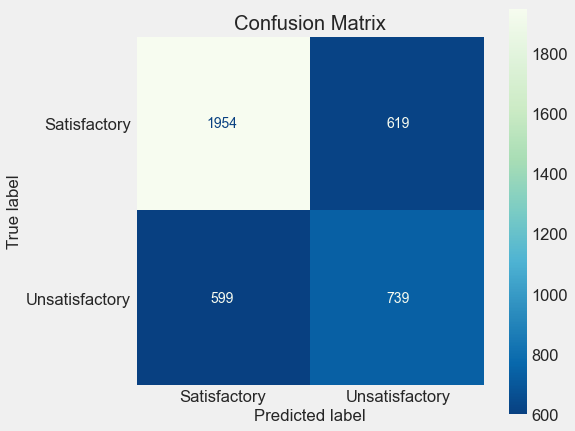

,Accuracy,F1,Recall,Precision
0,0.688571,0.54822,0.552317,0.544183


time: 244 ms


In [60]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [61]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 833 µs


In [62]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 1.09 ms


### Fitting Model

In [63]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.56 s


In [64]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 775 µs


### Cross Val Scores

In [65]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.76165698824314
bclf_ss has an average F1 of 0.6040450051408683
bclf_ss has an average Recall of 0.5315068493150685
bclf_ss has an average Precision of 0.6999414167788311


[0.76165698824314, 0.6040450051408683, 0.5315068493150685, 0.6999414167788311]

time: 13.5 s


### Test Data Confusion Matrix

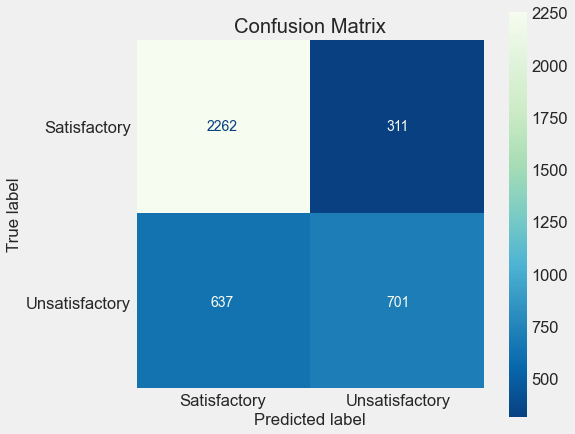

,Accuracy,F1,Recall,Precision
0,0.757607,0.596596,0.523916,0.692688


time: 299 ms


In [66]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [67]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 960 µs


In [68]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 1.11 ms


### Fitting Model

In [69]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.44 s


In [70]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 767 µs


### Cross Val Scores

In [71]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7689876721330055
rf_ss has an average F1 of 0.623409553030141
rf_ss has an average Recall of 0.5591531755915318
rf_ss has an average Precision of 0.7049275595750224


[0.7689876721330055, 0.623409553030141, 0.5591531755915318, 0.7049275595750224]

time: 13.6 s


### Test Data Confusion Matrix

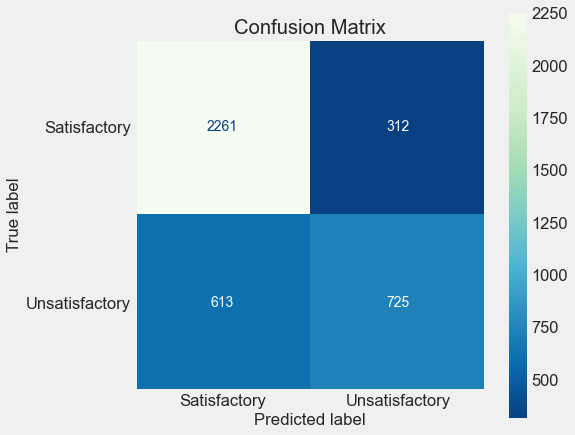

,Accuracy,F1,Recall,Precision
0,0.763488,0.610526,0.541854,0.699132


time: 640 ms


In [72]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [73]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 936 µs


In [74]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.07 ms


### Fitting Model

In [75]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 579 ms


In [76]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 1.2 ms


### Cross Val Scores

In [77]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6896252530392866
ada_ss has an average F1 of 0.5502520206442159
ada_ss has an average Recall of 0.5549190535491906
ada_ss has an average Precision of 0.5460631204366214


[0.6896252530392866,
 0.5502520206442159,
 0.5549190535491906,
 0.5460631204366214]

time: 2.33 s


### Test Data Confusion Matrix

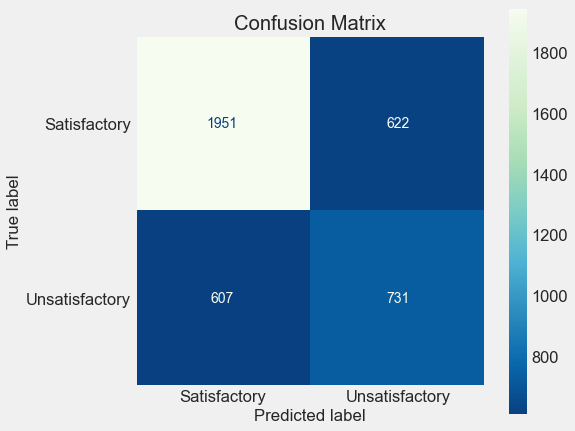

,Accuracy,F1,Recall,Precision
0,0.685758,0.543292,0.546338,0.540281


time: 306 ms


In [78]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [79]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 969 µs


In [80]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 959 µs


### Fitting Model

In [81]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.33 s


In [82]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 788 µs


### Cross Val Scores

In [83]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.7706921571170102,
 0.6356970060716768,
 0.5845579078455791,
 0.6968953509215996]

time: 6.78 s


### Test Data Confusion Matrix

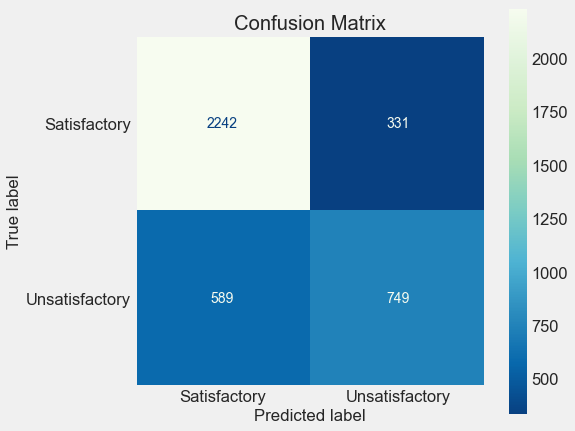

,Accuracy,F1,Recall,Precision
0,0.764766,0.61952,0.559791,0.693519


time: 471 ms


In [84]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [85]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.265575,Baseline DummyCFL
1,fsm,0.662177,0.239477,0.155417,0.523017,0.236777,FSM Naive Bayes
2,lsvc_ss,0.745887,0.561054,0.474471,0.686740,3.178427,Linear SVC SS()
3,logreg_ss,0.746057,0.568553,0.488917,0.679560,2.192683,LogReg SS()
4,svc_ss,0.757224,0.584450,0.498879,0.705680,25.814827,Support Vector CLF SS()
5,knn_ss,0.720229,0.554779,0.509340,0.609280,5.285169,KNN SS()
6,bclf_ss,0.761657,0.604045,0.531507,0.699941,13.501039,Bagging CLF SS()
7,ada_ss,0.689625,0.550252,0.554919,0.546063,2.324478,AdaBoost SS()
8,dt_ss,0.690818,0.552633,0.558157,0.547493,2.359925,Decision Tree CLF SS()
9,rf_ss,0.768988,0.623410,0.559153,0.704928,13.608782,Random Forest SS()


time: 12 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [86]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.25 ms


In [87]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.28 ms


### Fitting Model

In [88]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 6.31 s


In [89]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 727 µs


### Cross Val Scores

In [90]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.7762332861489755,
 0.6402615273266868,
 0.5823163138231631,
 0.7115724474008545]

time: 24.6 s


### Test Data Confusion Matrix

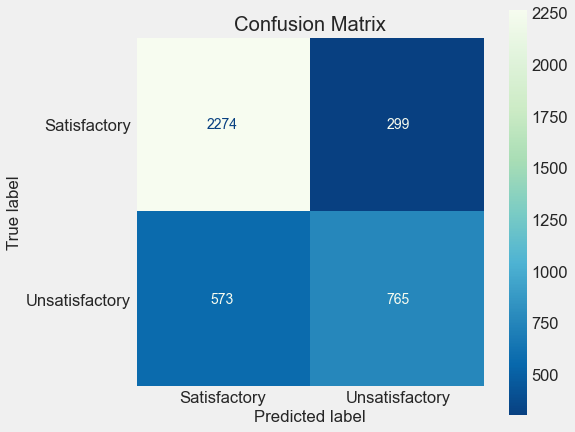

,Accuracy,F1,Recall,Precision
0,0.777039,0.636969,0.571749,0.718985


time: 1 s


In [91]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [92]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.265575,Baseline DummyCFL
1,fsm,0.662177,0.239477,0.155417,0.523017,0.236777,FSM Naive Bayes
2,lsvc_ss,0.745887,0.561054,0.474471,0.686740,3.178427,Linear SVC SS()
3,logreg_ss,0.746057,0.568553,0.488917,0.679560,2.192683,LogReg SS()
4,svc_ss,0.757224,0.584450,0.498879,0.705680,25.814827,Support Vector CLF SS()
5,knn_ss,0.720229,0.554779,0.509340,0.609280,5.285169,KNN SS()
6,bclf_ss,0.761657,0.604045,0.531507,0.699941,13.501039,Bagging CLF SS()
7,ada_ss,0.689625,0.550252,0.554919,0.546063,2.324478,AdaBoost SS()
8,dt_ss,0.690818,0.552633,0.558157,0.547493,2.359925,Decision Tree CLF SS()
9,rf_ss,0.768988,0.623410,0.559153,0.704928,13.608782,Random Forest SS()


time: 9.39 ms


## SMOTE

## XGBoost SMOTE

In [93]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.21 ms


### Fitting Model

In [94]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.91 s


In [95]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 776 µs


### Cross Val Scores

In [96]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.7745281836637509,
 0.6511560885519926,
 0.6149439601494396,
 0.6921637029620579]

time: 11.4 s


### Test Data Confusion Matrix

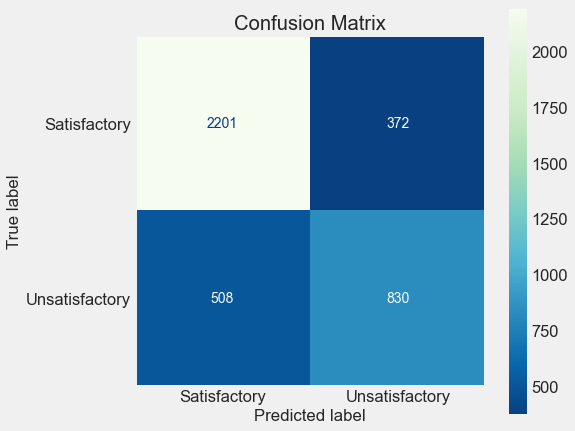

,Accuracy,F1,Recall,Precision
0,0.774994,0.653543,0.620329,0.690516


time: 457 ms


In [97]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Voting CLF SMOTE

In [98]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.48 ms


In [99]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.12 ms


### Fitting Model

In [100]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 10.2 s


In [101]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 793 µs


### Cross Val Scores

In [102]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE SOFT')

[0.7687319539809032,
 0.6541392347696597,
 0.6391033623910337,
 0.6699483805089578]

time: 38 s


### Test Data Confusion Matrix

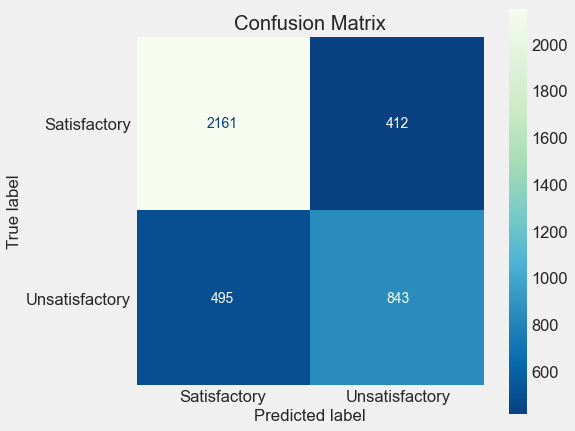

,Accuracy,F1,Recall,Precision
0,0.76809,0.650212,0.630045,0.671713


time: 902 ms


In [103]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [104]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.265575,Baseline DummyCFL
1,fsm,0.662177,0.239477,0.155417,0.523017,0.236777,FSM Naive Bayes
2,lsvc_ss,0.745887,0.561054,0.474471,0.686740,3.178427,Linear SVC SS()
3,logreg_ss,0.746057,0.568553,0.488917,0.679560,2.192683,LogReg SS()
4,svc_ss,0.757224,0.584450,0.498879,0.705680,25.814827,Support Vector CLF SS()
5,knn_ss,0.720229,0.554779,0.509340,0.609280,5.285169,KNN SS()
6,bclf_ss,0.761657,0.604045,0.531507,0.699941,13.501039,Bagging CLF SS()
7,ada_ss,0.689625,0.550252,0.554919,0.546063,2.324478,AdaBoost SS()
8,dt_ss,0.690818,0.552633,0.558157,0.547493,2.359925,Decision Tree CLF SS()
9,rf_ss,0.768988,0.623410,0.559153,0.704928,13.608782,Random Forest SS()


time: 14.3 ms


## Feature Importances

## XGBoost

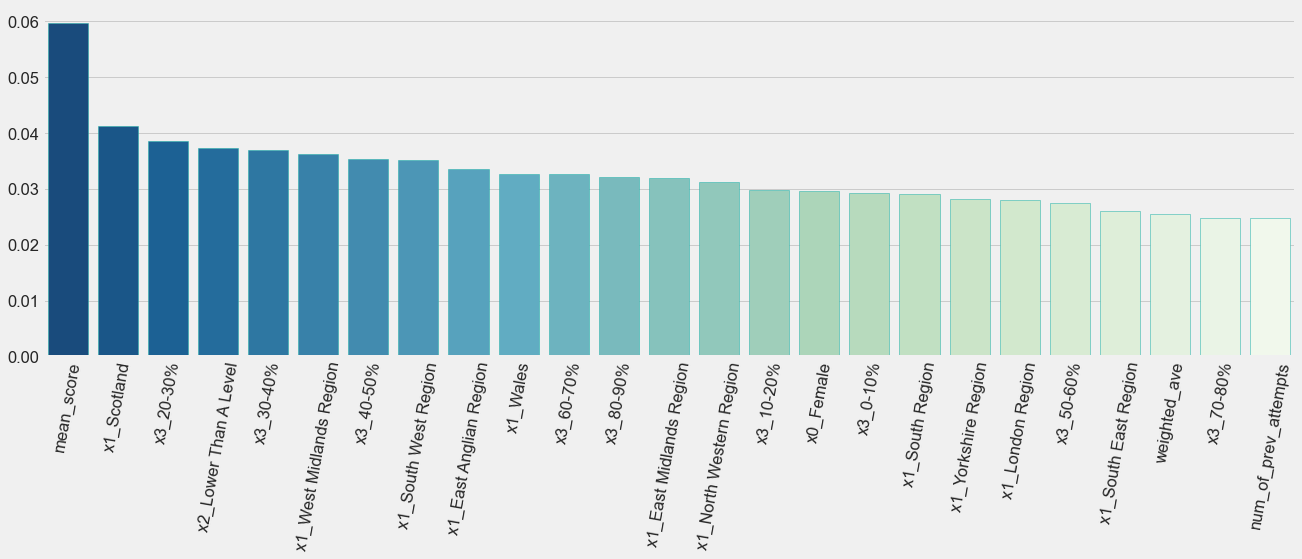

time: 484 ms


In [105]:
v.importance_plot_sm(xgb_sm, X_train)

In [106]:
# feature legend
keys = range(12)
f.get_features(keys, X_train)

0 gender
1 region
2 highest_education
3 imd_band
4 age_band
5 num_of_prev_attempts
6 disability
7 weighted_ave
8 mean_score
9 median_score
10 sum_activity
11 course_load
time: 1.65 ms


## Bagging Classifier

In [107]:
bclf_sm = make_sm_pipeline(preprocessing_ss, BCLF)
bclf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 4.2 s


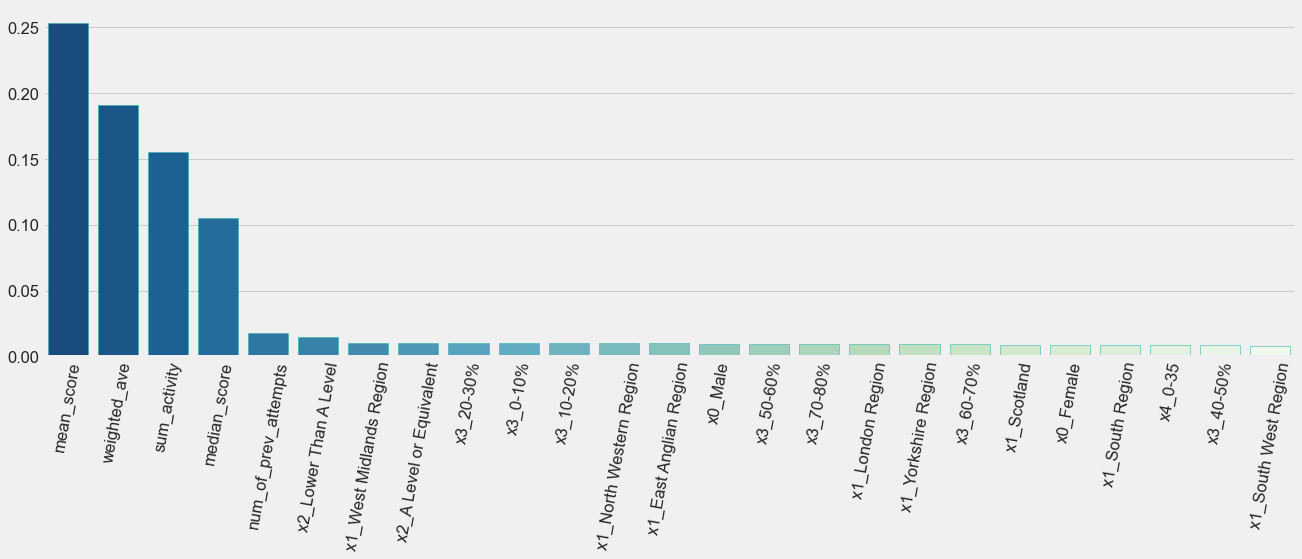

time: 406 ms


In [108]:
v.importance_plot_bclf(bclf_sm, X_train)

## Random Forest Classifier

In [109]:
rf_sm = make_sm_pipeline(preprocessing_ss, RF)
rf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.53 s


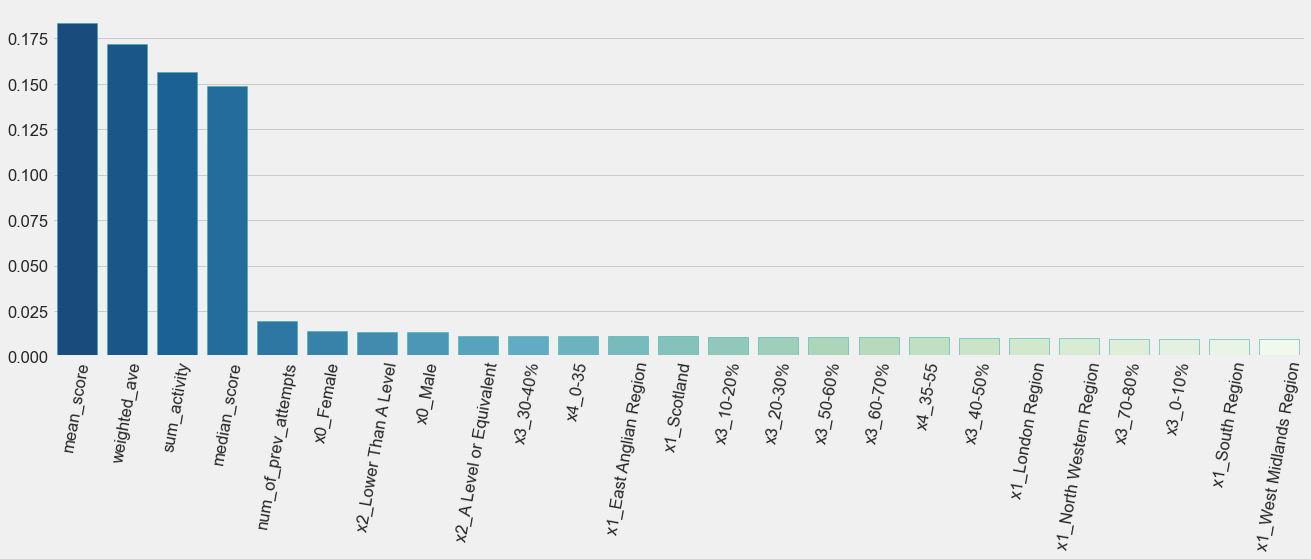

time: 428 ms


In [110]:
v.importance_plot(rf_sm, X_train)

## Permutation Importances

## Accuracy

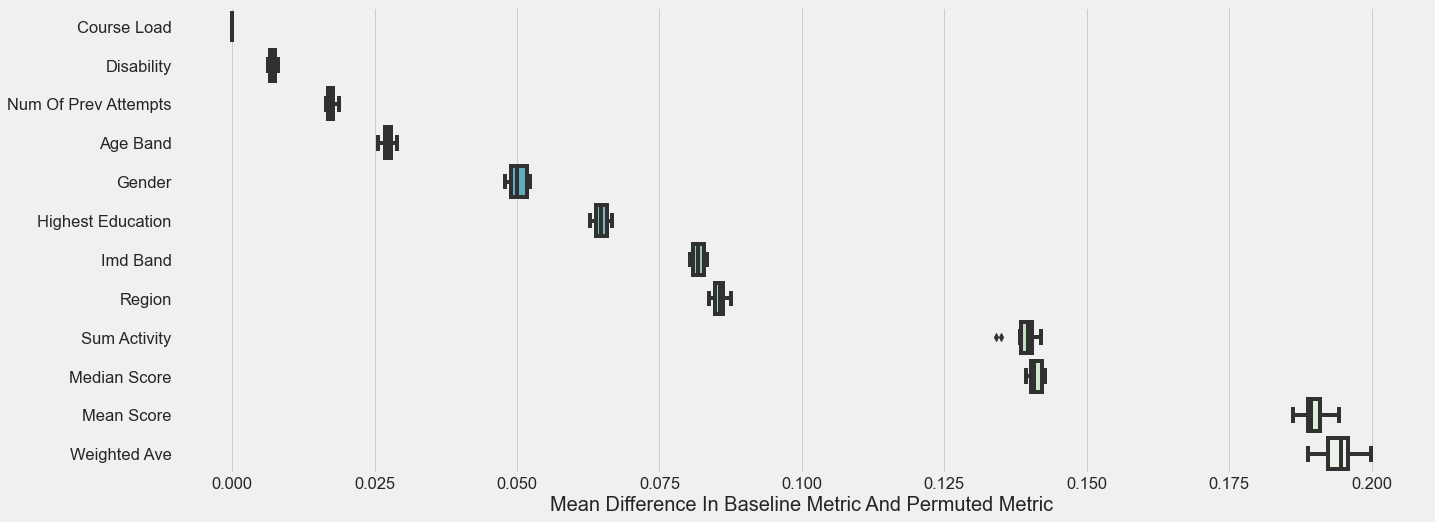

time: 20.9 s


In [111]:
f.perm_importances(vc_ss, X_train, y_train, 'accuracy')

## F1

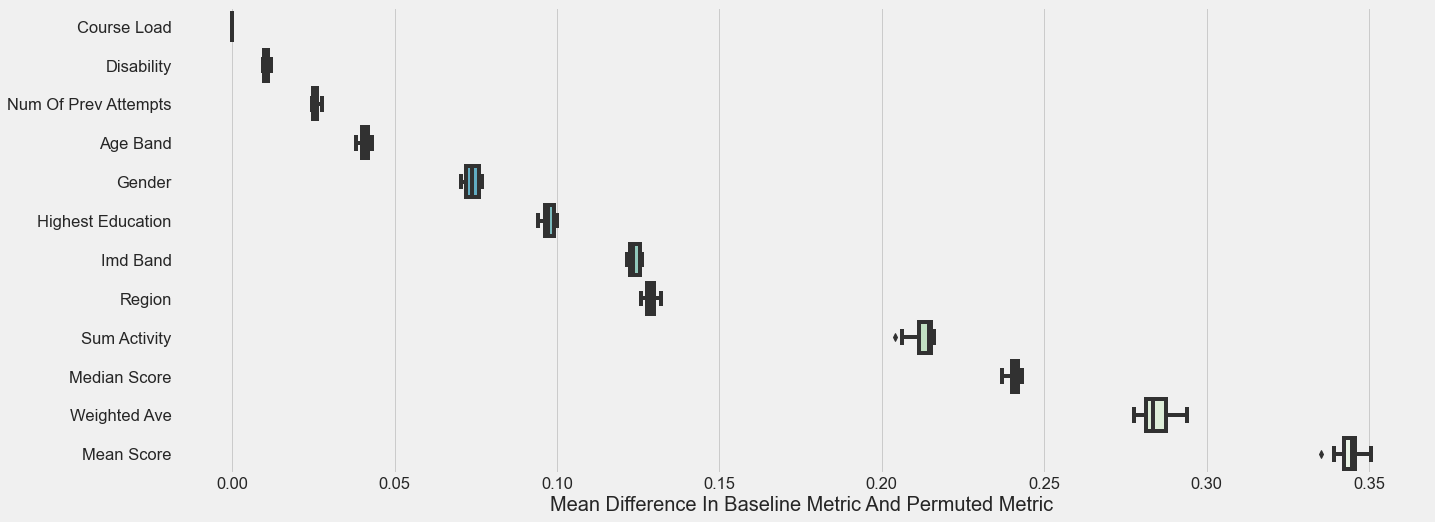

time: 20.1 s


In [112]:
f.perm_importances(vc_ss, X_train, y_train, 'f1')

## Recall

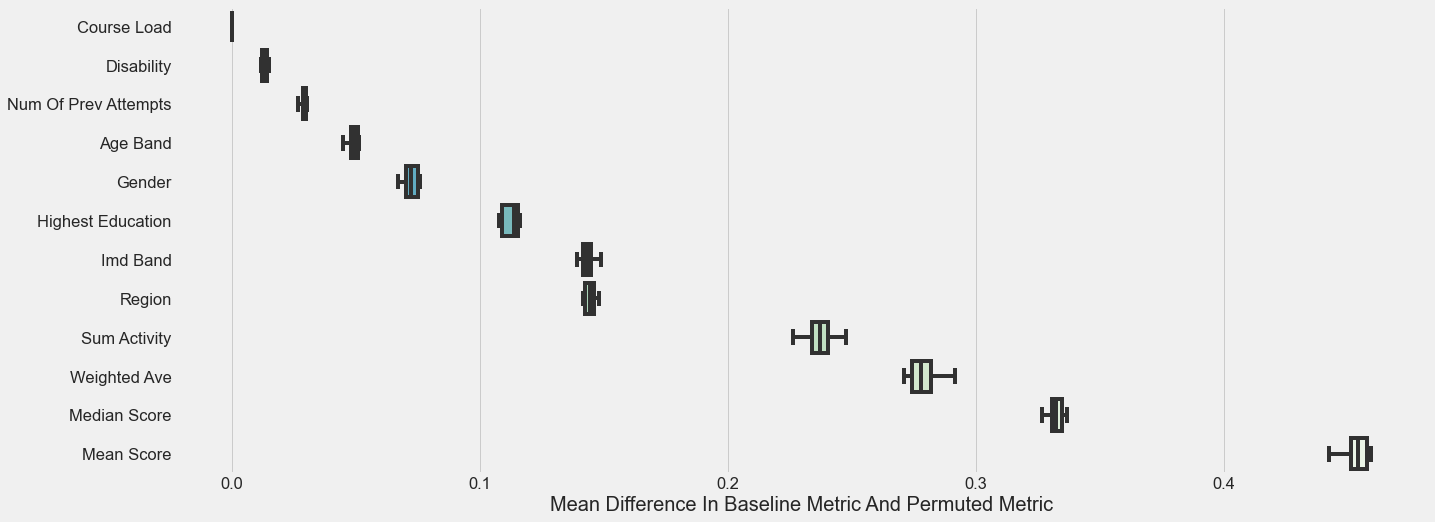

time: 18.7 s


In [113]:
f.perm_importances(vc_ss, X_train, y_train, 'recall')

## Precision

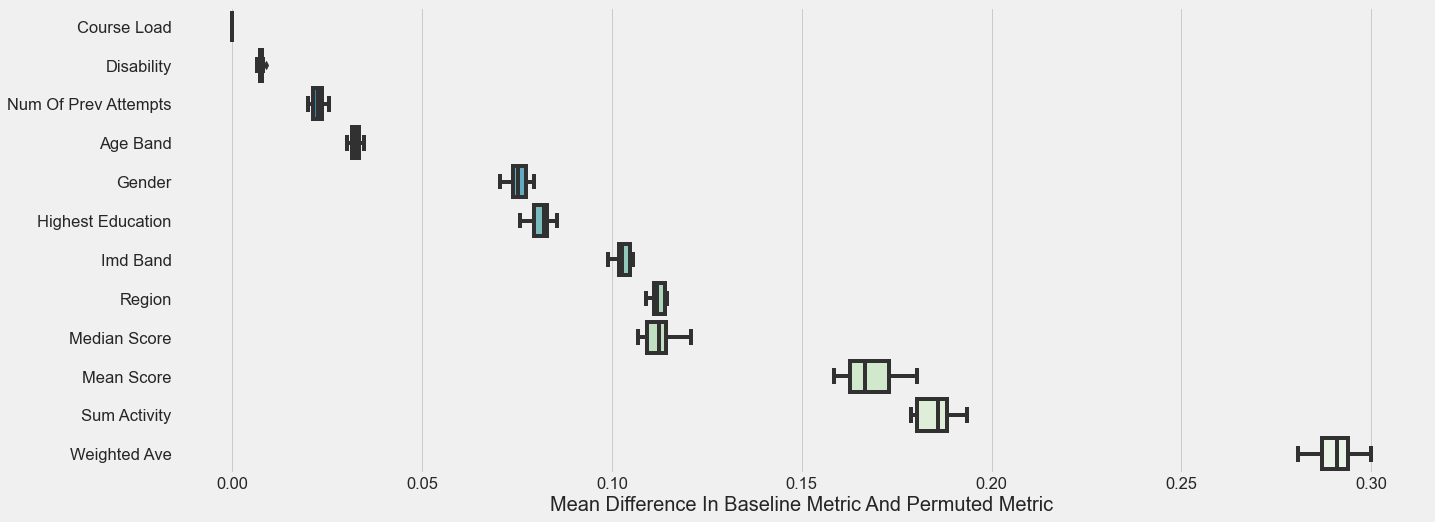

time: 23.4 s


In [114]:
f.perm_importances(vc_ss, X_train, y_train, 'precision')

In [115]:
vc_ss.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'smote', 'votingclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifie

time: 4.01 ms


In [116]:
bag_params = ['votingclassifier__bclf__base_estimator__ccp_alpha', 
              'votingclassifier__bclf__base_estimator__class_weight',
              'votingclassifier__bclf__base_estimator__criterion', 
              'votingclassifier__bclf__base_estimator__max_depth', 
              'votingclassifier__bclf__base_estimator__max_features', 
              'votingclassifier__bclf__base_estimator__max_leaf_nodes', 
              'votingclassifier__bclf__base_estimator__min_impurity_decrease', 
              'votingclassifier__bclf__base_estimator__min_impurity_split', 
              'votingclassifier__bclf__base_estimator__min_samples_leaf', 
              'votingclassifier__bclf__base_estimator__min_samples_split', 
              'votingclassifier__bclf__base_estimator__min_weight_fraction_leaf', 
              'votingclassifier__bclf__base_estimator__random_state', 
              'votingclassifier__bclf__base_estimator__splitter', 
              'votingclassifier__bclf__base_estimator', 
              'votingclassifier__bclf__bootstrap', 
              'votingclassifier__bclf__bootstrap_features', 
              'votingclassifier__bclf__max_features', 
              'votingclassifier__bclf__max_samples',
              'votingclassifier__bclf__n_estimators', 
              'votingclassifier__bclf__n_jobs', 
              'votingclassifier__bclf__oob_score', 
              'votingclassifier__bclf__random_state', 
              'votingclassifier__bclf__verbose', 
              'votingclassifier__bclf__warm_start']

time: 2.12 ms


In [117]:
rf_params = ['votingclassifier__rf__bootstrap',
             'votingclassifier__rf__ccp_alpha', 
             'votingclassifier__rf__class_weight', 
             'votingclassifier__rf__criterion', 
             'votingclassifier__rf__max_depth', 
             'votingclassifier__rf__max_features', 
             'votingclassifier__rf__max_leaf_nodes', 
             'votingclassifier__rf__max_samples', 
             'votingclassifier__rf__min_impurity_decrease', 
             'votingclassifier__rf__min_impurity_split', 
             'votingclassifier__rf__min_samples_leaf', 
             'votingclassifier__rf__min_samples_split', 
             'votingclassifier__rf__min_weight_fraction_leaf', 
             'votingclassifier__rf__n_estimators', 
             'votingclassifier__rf__n_jobs', 
             'votingclassifier__rf__oob_score', 
             'votingclassifier__rf__random_state', 
             'votingclassifier__rf__verbose',
             'votingclassifier__rf__warm_start']

time: 1.67 ms


In [118]:
xgb_params = ['votingclassifier__xgb__objective', 
              'votingclassifier__xgb__use_label_encoder', 
              'votingclassifier__xgb__base_score', 
              'votingclassifier__xgb__booster', 
              'votingclassifier__xgb__colsample_bylevel', 
              'votingclassifier__xgb__colsample_bynode', 
              'votingclassifier__xgb__colsample_bytree', 
              'votingclassifier__xgb__gamma', 
              'votingclassifier__xgb__gpu_id', 
              'votingclassifier__xgb__importance_type', 
              'votingclassifier__xgb__interaction_constraints', 
              'votingclassifier__xgb__learning_rate', 
              'votingclassifier__xgb__max_delta_step', 
              'votingclassifier__xgb__max_depth', 
              'votingclassifier__xgb__min_child_weight', 
              'votingclassifier__xgb__missing', 
              'votingclassifier__xgb__monotone_constraints', 
              'votingclassifier__xgb__n_estimators', 
              'votingclassifier__xgb__n_jobs', 
              'votingclassifier__xgb__num_parallel_tree', 
              'votingclassifier__xgb__random_state', 
              'votingclassifier__xgb__reg_alpha', 
              'votingclassifier__xgb__reg_lambda', 
              'votingclassifier__xgb__scale_pos_weight', 
              'votingclassifier__xgb__subsample', 
              'votingclassifier__xgb__tree_method', 
              'votingclassifier__xgb__validate_parameters', 
              'votingclassifier__xgb__verbosity']

time: 1.8 ms


In [119]:
grid = {'votingclassifier__bclf__base_estimator__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__bclf__base_estimator__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__bclf__base_estimator__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__bclf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__rf__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__rf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__rf__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__xgb__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__xgb__colsample_bytree':\
        np.linspace(0.5, 1.0, 10),
        'votingclassifier__xgb__gamma':\
        np.linspace(0, .5, 5),
        'votingclassifier__xgb__learning_rate':\
        np.linspace(0.01, .5, 10),
        'votingclassifier__xgb__max_depth':\
        np.linspace(3, 10, 7, dtype='int'),
        'votingclassifier__xgb__reg_alpha':\
        np.logspace(.001, 2, 10),
        'votingclassifier__xgb__reg_lambda':\
        np.linspace(1, 10, 20)
       }

time: 2.96 ms


In [120]:
param_search = RandomizedSearchCV(vc_ss, param_distributions=grid,
                                  scoring='f1', random_state=2021, cv=3)

time: 1.03 ms


In [121]:
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c970>),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x10f78c910>...
                                        'votingclassifier__xgb__reg_alpha': array([  1.00230524,   1.67151821,   2.78754715,   4.64871941,
         7.75254765,  12.92872076, 

time: 1min 3s


In [122]:
search_results = pd.DataFrame(param_search.cv_results_)\
.sort_values(by='rank_test_score').reset_index(drop=True)

time: 13.6 ms


In [123]:
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingclassifier__xgb__reg_lambda,param_votingclassifier__xgb__reg_alpha,param_votingclassifier__xgb__n_estimators,param_votingclassifier__xgb__max_depth,param_votingclassifier__xgb__learning_rate,param_votingclassifier__xgb__gamma,...,param_votingclassifier__bclf__base_estimator__min_samples_split,param_votingclassifier__bclf__base_estimator__min_samples_leaf,param_votingclassifier__bclf__base_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.818082,0.056751,0.168518,0.011903,1.947368,21.560889,74,5,0.118889,0.25,...,0.9,0.4,20.0,{'votingclassifier__xgb__reg_lambda': 1.947368...,0.648327,0.666667,0.642857,0.652617,0.010183,1
1,1.283118,0.019815,0.084824,0.001211,3.842105,7.752548,21,10,0.173333,0.125,...,0.2,0.5,21.0,{'votingclassifier__xgb__reg_lambda': 3.842105...,0.647590,0.664134,0.636639,0.649454,0.011302,2
2,4.228798,0.536491,0.098413,0.019860,7.157895,2.787547,179,7,0.391111,0.375,...,0.7,0.3,22.0,{'votingclassifier__xgb__reg_lambda': 7.157894...,0.662553,0.632405,0.636648,0.643869,0.013325,3
3,1.035564,0.079982,0.071857,0.005213,7.157895,100.0,42,6,0.336667,0.25,...,0.2,0.3,27.0,{'votingclassifier__xgb__reg_lambda': 7.157894...,0.645482,0.650514,0.634686,0.643561,0.006603,4
4,1.790423,0.088413,0.190786,0.039690,5.263158,100.0,32,4,0.173333,0.375,...,0.3,0.1,31.0,{'votingclassifier__xgb__reg_lambda': 5.263157...,0.649601,0.646358,0.630193,0.642050,0.008489,5


time: 43.4 ms


In [124]:
param_search.best_params_

{'votingclassifier__xgb__reg_lambda': 1.9473684210526314,
 'votingclassifier__xgb__reg_alpha': 21.5608891451648,
 'votingclassifier__xgb__n_estimators': 74,
 'votingclassifier__xgb__max_depth': 5,
 'votingclassifier__xgb__learning_rate': 0.11888888888888888,
 'votingclassifier__xgb__gamma': 0.25,
 'votingclassifier__xgb__colsample_bytree': 1.0,
 'votingclassifier__rf__n_estimators': 200,
 'votingclassifier__rf__min_samples_split': 1.0,
 'votingclassifier__rf__min_samples_leaf': 0.4,
 'votingclassifier__rf__max_features': 2,
 'votingclassifier__rf__max_depth': 4.0,
 'votingclassifier__bclf__max_features': 9,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.9,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.4,
 'votingclassifier__bclf__base_estimator__max_depth': 20.0}

time: 4.39 ms


best_params_f1 =

{'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}
 
ACC 0.761953 F1 0.652223 RC 0.652466 PR 0.651979

num_num_previous

best_params = {'votingclassifier__xgb__reg_lambda': 1.9473684210526314,
 'votingclassifier__xgb__reg_alpha': 21.5608891451648,
 'votingclassifier__xgb__n_estimators': 74,
 'votingclassifier__xgb__max_depth': 5,
 'votingclassifier__xgb__learning_rate': 0.11888888888888888,
 'votingclassifier__xgb__gamma': 0.25,
 'votingclassifier__xgb__colsample_bytree': 1.0,
 'votingclassifier__rf__n_estimators': 200,
 'votingclassifier__rf__min_samples_split': 1.0,
 'votingclassifier__rf__min_samples_leaf': 0.4,
 'votingclassifier__rf__max_features': 2,
 'votingclassifier__rf__max_depth': 4.0,
 'votingclassifier__bclf__max_features': 9,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.9,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.4,
 'votingclassifier__bclf__base_estimator__max_depth': 20.0}

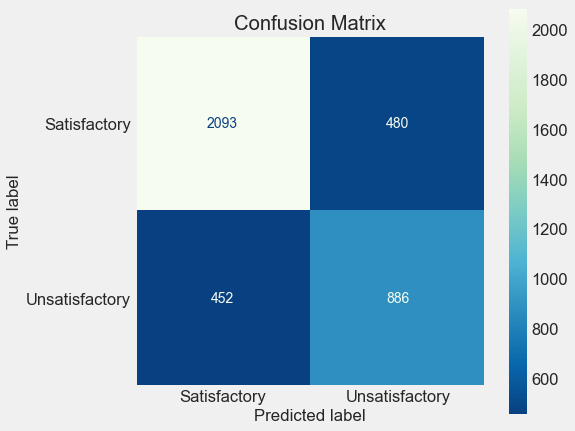

,Accuracy,F1,Recall,Precision
0,0.761698,0.655325,0.662182,0.648609


time: 1.34 s


In [125]:
best_model = param_search.best_estimator_

f.confusion_report(best_model, X_test, y_test)

ACC 0.761953 F1 0.652223 RC 0.652466 PR 0.651979

num_num_prev

ACC 0.761698 F10.655325 RC 0.662182 PR0.648609

## Saving Model

In [126]:
# f.pickle_model(best_model, 'xgb_f1_tuned')

time: 1.13 ms


## ROC AUC Test

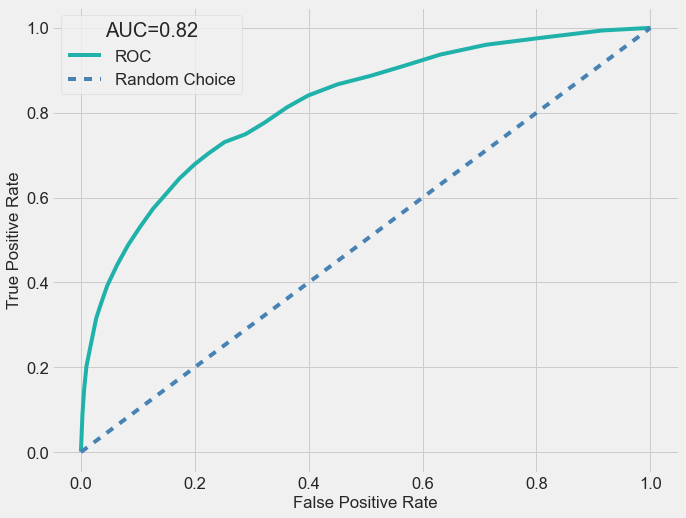

time: 1.35 s


In [127]:
f.roc_auc(best_model, X_test, y_test)

In [128]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 264 ms
